In [973]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import re

reddit_ds = pd.read_csv('reddit_ds.csv')
reddit_ml = pd.read_csv('reddit_ml.csv')
reddit_ds = reddit_ds.iloc[:,1:5]
reddit_ml = reddit_ml.iloc[:,1:8]
reddit_ml = reddit_ml.astype({'title':str,'date':str,
                              'genre':str,'reply':int,
                              'support':str})



for i in range(reddit_ml.shape[0]):
    # clean the genre column, which is not correct in the raw file
    if (reddit_ml["title"][i][:3] == '[R]'):
        reddit_ml.loc[:,"genre"][i] = 'Research'
    elif (reddit_ml["title"][i][:3] == '[D]'):
        reddit_ml.loc[:,"genre"][i] = 'Discussion'
    elif (reddit_ml["title"][i][:3] == '[N]'):
        reddit_ml.loc[:,"genre"][i] = 'News'
    elif (reddit_ml["title"][i][:3] == '[P]'):
        reddit_ml.loc[:,"genre"][i] = 'Project'
    else:
        reddit_ml.loc[:,"genre"][i] = 'General'
    # clean the support column which contains something like 1.1k and transfer to numbers    
    if (reddit_ml.loc[i,'support'][-1] == 'k'):
        reddit_ml.loc[i,'support'] = float(reddit_ml.loc[i,'support'][:-1]) * 1000
    else:
        reddit_ml.loc[i,'support'] = float(reddit_ml.loc[i,'support'])
    
    # clean the date column and set them with same unit of months
    if ('month' in reddit_ml.loc[i,'date']):
        reddit_ml.loc[i,'date'] = float(re.findall('[1-9]+', reddit_ml.loc[i,'date'])[0])
    elif ('year' in reddit_ml.loc[i,'date']):
        reddit_ml.loc[i,'date'] = float(re.findall('[1-9]+', reddit_ml.loc[i,'date'])[0]) * 12
    else:
        reddit_ml.loc[i,'date'] = float(re.findall('[1-9]+', reddit_ml.loc[i,'date'])[0])/30

# reset the column names and types
reddit_ml = reddit_ml.rename(columns={'date': 'date_months_ago',
                 'reply': 'num_of_reply',
                 'support': 'num_of_support'})

reddit_ml = reddit_ml.astype({'num_of_reply':int,
                              'num_of_support':int})   

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to 

In [1839]:
reddit_ml12312 = pd.read_csv('reddit_ml.csv').drop('Unnamed: 0', axis= 1)

In [1857]:
reddit_ml.sort_values('num_of_support', ascending = False).head(5)

,title,date_months_ago,genre,num_of_reply,num_of_support
148,[r] neural color transfer between images,12,Research,9,2300
950,[r] deep images analogy,24,Research,123,1700
984,[p] realtime multihand pose estimaion demo,12,Project,142,1700
1040,[d] why can't you guys comment your fucking code?,24,Discussion,489,1600
1022,[d] a super harsh guide to machine-learning,24,Discussion,255,1500


In [1547]:
#set the uncommon_words which will not be counted 
uncommon_words = stopwords.words('english') + ['[',']','d','r','n','p',"'s",'``',"''"]

# replace some important info in the title
reddit_ml['title'] = reddit_ml['title'].str.lower()
reddit_ml.title = reddit_ml.title.str.replace('machine learning',"machine-learning")
reddit_ml.title = reddit_ml.title.str.replace('ml',"machine-learning")
reddit_ml.title = reddit_ml.title.str.replace('deep learning',"deep-learning")
reddit_ml.title = reddit_ml.title.str.replace('a.i',"ai")
reddit_ml.title = reddit_ml.title.str.replace('/', ' ')

# function to count the words, support number, reply numbers
def count(raw_df):
    word_count = {}
    sup_count = {}
    rep_count = {}
    for i in range(raw_df.shape[0]):
        word_title = word_tokenize(raw_df['title'][i])
        for word in word_title:
            if ((word in uncommon_words) | (len(word) == 1)) == False:
                if word in word_count:
                    word_count[word] += 1
                    sup_count[word] += raw_df.num_of_support[i]
                    rep_count[word] += raw_df.num_of_reply[i]
                else:
                    word_count[word] = 1
                    sup_count[word] = raw_df.num_of_support[i]
                    rep_count[word] = raw_df.num_of_reply[i]

    word_count_df = pd.DataFrame(list(word_count.items()), columns = ['words','counts'])
    sup_count_df = pd.DataFrame(list(sup_count.items()), columns = ['words','sup_counts'])
    rep_count_df = pd.DataFrame(list(rep_count.items()), columns = ['words','rep_counts'])
    count_df = merge_multi('words', word_count_df,sup_count_df,rep_count_df)
    return count_df
reddit_ml_count = count(reddit_ml)
reddit_ml_count.loc[:,'ave_sup']  = reddit_ml_count.loc[:,'sup_counts']//reddit_ml_count.loc[:, 'counts']
reddit_ml_count.loc[:,'ave_rep'] = reddit_ml_count.loc[:,'rep_counts']//reddit_ml_count.loc[:, 'counts']
reddit_ml_count1=reddit_ml_count.sort_values('ave_sup', ascending = False).drop([1036,308,673,92,993,19,41,2940, 2553, 2934,2919,720,2093])

# fucntion to mergy multiple dataframes by x
def merge_multi(x, *args):
    df = args[0]
    for arg in args[1:]:
        df = pd.merge(df, arg,how='outer',on = x)
    return df



In [1828]:
reddit_ml_count.sort_values('counts', ascending = False)

,words,counts,sup_counts,rep_counts,ave_sup,ave_rep
19,machine-learning,198,65425,10390,330,52
117,neural,103,30738,4353,298,42
3,ai,100,32408,5277,324,52
124,deep-learning,90,27244,3775,302,41
36,google,77,26327,5188,341,67
100,tensorflow,75,22388,3111,298,41
243,networks,71,20247,2662,285,37
230,papers,61,19519,4037,319,66
41,using,57,16931,2901,297,50
189,learning,53,15557,2148,293,40


# from pylab import savefig
import matplotlib.pyplot as plt
bar_df = reddit_ml_count.sort_values('counts', ascending = False).drop([41,281]).iloc[:40, 0:2]
count_plots = sns.barplot(x= 'counts', y='words', data = bar_df)
count_plots = sns.set(rc={'figure.figsize':(15, 7)},
                     style='white')
plt.savefig('count_plots.pdf', dpi=400)



In [1030]:
# filter by genre and creat new datafames
d_genre = reddit_ml[reddit_ml.loc[:,'genre']=='Discussion'].reset_index()
r_genre = reddit_ml[reddit_ml.loc[:,'genre']=='Research'].reset_index()
n_genre = reddit_ml[reddit_ml.loc[:,'genre']=='News'].reset_index()
p_genre = reddit_ml[reddit_ml.loc[:,'genre']=='Project'].reset_index()
g_genre = reddit_ml[reddit_ml.loc[:,'genre']=='General'].reset_index()


discussion_count = count(d_genre).sort_values('counts', ascending = False)
research_count = count(r_genre).sort_values('counts', ascending = False)
news_count = count(n_genre).sort_values('counts', ascending = False)
project_count = count(p_genre).sort_values('counts', ascending = False)
general_count = count(g_genre).sort_values('counts', ascending = False)

# rename the columns in case of merging comfusion
discussion_count.rename(columns = {'counts':'d_counts',
                        'sup_counts':'dsup_counts',
                        'rep_counts':'drep_counts'},
                       inplace = True)

research_count.rename(columns = {'counts':'r_counts',
                        'sup_counts':'rsup_counts',
                        'rep_counts':'rrep_counts'},
                         inplace = True)

news_count.rename(columns = {'counts':'n_counts',
                        'sup_counts':'nsup_counts',
                        'rep_counts':'nrep_counts'},
                     inplace = True)

project_count.rename(columns = {'counts':'p_counts',
                        'sup_counts':'psup_counts',
                        'rep_counts':'prep_counts'},
                        inplace = True)

general_count.rename(columns = {'counts':'g_counts',
                        'sup_counts':'gsup_counts',
                        'rep_counts':'grep_counts'},
                        inplace = True)

# mergy these columns and drop some rows contain uncommon words
count_by_genre = merge_multi('words', 
                             discussion_count,research_count,news_count,
                             project_count, general_count).fillna(0)



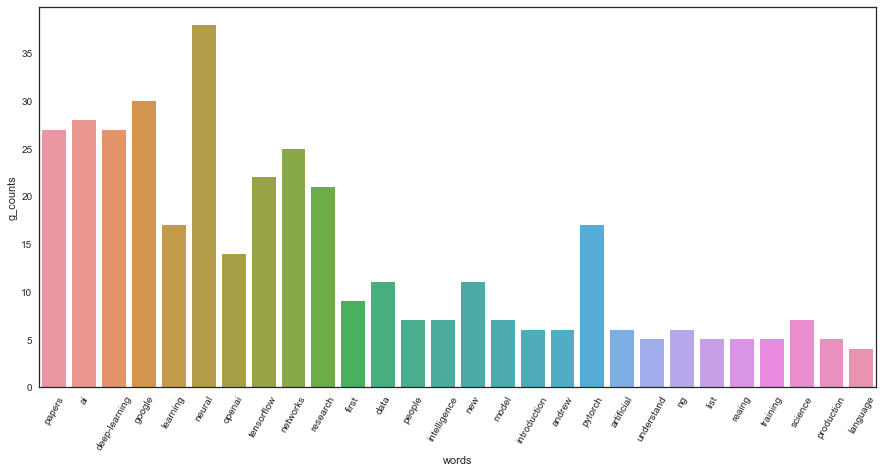

In [1863]:
bar_genre_df = count_by_genre.sort_values('d_counts', ascending = False).drop([0,23,25,27,28,29,30,40,43,58,61,64],axis = 0).head(30)
d_count_plots = sns.barplot(x= 'words', y='d_counts', data = bar_genre_df.iloc[:-2,:])
d_count_plots.set_xticklabels(labels = bar_genre_df['words'],rotation=60)
d_count_plots = sns.set(style = 'white')

plt.savefig('d_count_plots.pdf', dpi=400)

r_count_plots = sns.barplot(x= 'words', y='r_counts', data = bar_genre_df.iloc[:-2,:])
r_count_plots.set_xticklabels(labels = bar_genre_df['words'],rotation=60)
r_count_plots = sns.set(style='white')
plt.savefig('r_count_plots.pdf', dpi=400)

n_count_plots = sns.barplot(x= 'words', y='n_counts', data = bar_genre_df.iloc[:-2,:])
n_count_plots.set_xticklabels(labels = bar_genre_df['words'],rotation=60)
n_count_plots = sns.set(style='white')
plt.savefig('n_count_plots.pdf', dpi=400)


p_count_plots = sns.barplot(x= 'words', y='p_counts', data = bar_genre_df.iloc[:-2,:])
p_count_plots.set_xticklabels(labels = bar_genre_df['words'],rotation=60)
p_count_plots = sns.set(style='white')
plt.savefig('p_count_plots.pdf', dpi=400)

g_count_plots = sns.barplot(x= 'words', y='g_counts', data = bar_genre_df.iloc[:-2,:])
g_count_plots.set_xticklabels(labels = bar_genre_df['words'],rotation=60)
g_count_plots = sns.set(style='white')
plt.savefig('g_count_plots.pdf', dpi=400)


In [ ]:
#!!! filter by genre and creat new datafames
d_genre = reddit_ml[reddit_ml.loc[:,'genre']=='Discussion'].reset_index()
r_genre = reddit_ml[reddit_ml.loc[:,'genre']=='Research'].reset_index()
n_genre = reddit_ml[reddit_ml.loc[:,'genre']=='News'].reset_index()
p_genre = reddit_ml[reddit_ml.loc[:,'genre']=='Project'].reset_index()
g_genre = reddit_ml[reddit_ml.loc[:,'genre']=='General'].reset_index()


discussion_count = count(d_genre).sort_values('counts', ascending = False)
research_count = count(r_genre).sort_values('counts', ascending = False)
news_count = count(n_genre).sort_values('counts', ascending = False)
project_count = count(p_genre).sort_values('counts', ascending = False)
general_count = count(g_genre).sort_values('counts', ascending = False)

# rename the columns in case of merging comfusion
discussion_count.rename(columns = {'counts':'d_counts',
                        'sup_counts':'dsup_counts',
                        'rep_counts':'drep_counts'},
                       inplace = True)

research_count.rename(columns = {'counts':'r_counts',
                        'sup_counts':'rsup_counts',
                        'rep_counts':'rrep_counts'},
                         inplace = True)

news_count.rename(columns = {'counts':'n_counts',
                        'sup_counts':'nsup_counts',
                        'rep_counts':'nrep_counts'},
                     inplace = True)

project_count.rename(columns = {'counts':'p_counts',
                        'sup_counts':'psup_counts',
                        'rep_counts':'prep_counts'},
                        inplace = True)

general_count.rename(columns = {'counts':'g_counts',
                        'sup_counts':'gsup_counts',
                        'rep_counts':'grep_counts'},
                        inplace = True)

# mergy these columns and drop some rows contain uncommon words
count_by_genre = merge_multi('words', 
                             discussion_count,research_count,news_count,
                             project_count, general_count).fillna(0)

count_by_genre.drop([11,12,13,14,16,18,26,32,33], axis = 0, inplace=True)

ratio_by_genre = pd.DataFrame()
names = count_by_genre.columns.values
for i in range(1,count_by_genre.shape[1]):
    ratio_by_genre.loc[:,names[i]] = count_by_genre.iloc[:,i]/count_by_genre.agg('sum')[i] * 100

    
sort_by_d_counts = count_by_genre.sort_values('d_counts', ascending = False).reset_index()
sort_by_d_counts.drop('index',axis=1, inplace = True)         
sort_by_r_counts = count_by_genre.sort_values('r_counts', ascending = False).reset_index()
sort_by_r_counts.drop('index',axis=1, inplace = True) 
sort_by_n_counts = count_by_genre.sort_values('n_counts', ascending = False).reset_index()
sort_by_n_counts.drop('index',axis=1, inplace = True) 
sort_by_g_counts = count_by_genre.sort_values('g_counts', ascending = False).reset_index()
sort_by_g_counts.drop('index',axis=1, inplace = True) 
sort_by_p_counts = count_by_genre.sort_values('p_counts', ascending = False).reset_index()
sort_by_p_counts.drop('index',axis=1, inplace = True) 

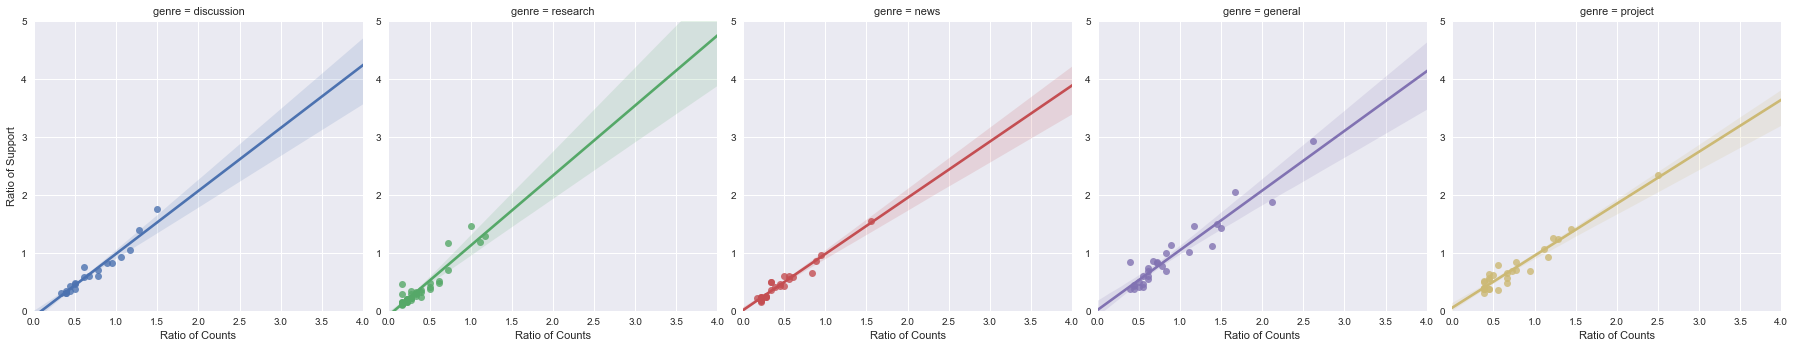

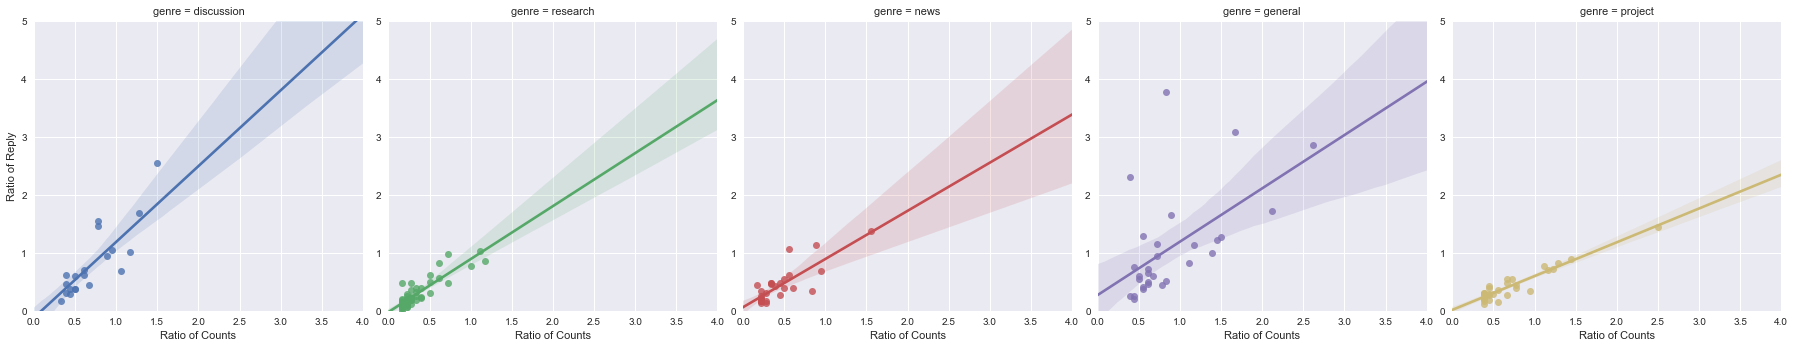

In [1815]:
#very important !!!!! combine all counts and sup/rep counts and calculate the ratio
discussion_count1 = count(d_genre).sort_values('counts', ascending = False)

research_count1 = count(r_genre).sort_values('counts', ascending = False)
news_count1 = count(n_genre).sort_values('counts', ascending = False)
project_count1 = count(p_genre).sort_values('counts', ascending = False)
general_count1 = count(g_genre).sort_values('counts', ascending = False)
discussion_count1.loc[:,'genre'] = 'discussion'
research_count1.loc[:,'genre'] = 'research'
news_count1.loc[:,'genre'] = 'news'
project_count1.loc[:,'genre'] = 'project'
general_count1.loc[:,'genre'] = 'general'

new_df = pd.DataFrame()
new_df = discussion_count1.head(30).append(research_count1.head(50))
new_df = new_df.append(news_count1.head(30))
new_df = new_df.append(general_count1.head(30))
new_df = new_df.append(project_count1.head(30))
new_df.loc[:,'ave_sup'] = new_df.loc[:,'sup_counts']/new_df.loc[:, 'counts']
new_df.loc[:,'ave_rep'] = new_df.loc[:,'rep_counts']/new_df.loc[:, 'counts']
new_ratio = pd.DataFrame() 
for i in range(1,4):
    new_ratio.loc[:,names[i]] = new_df.iloc[:,i]/new_df.agg('sum')[i] * 100
new_ratio.loc[:,'genre'] = new_df.loc[:,'genre']
new_ratio.loc[:,'words'] = new_df.loc[:,'words']
new_ratio.head(20)
new_ratio = new_ratio.drop([44,183,262,293,458,92,222,331,294,173,226,19,614], axis = 0)

# plot the counts and sup/rep counts
sup_fig = sns.lmplot("d_counts", "dsup_counts", new_ratio,hue = 'genre',col='genre')
rep_fig = sns.lmplot("d_counts", "drep_counts", new_ratio,hue = 'genre',col='genre')
sup_fig1 = sup_fig.set(xlim = [0,1.5], ylim = [0,2.2])
rep_fig1 = rep_fig.set(xlim = [0,1.5], ylim = [0,2.2])
sup_fig1.set_axis_labels('Ratio of Counts', 'Ratio of Support')
rep_fig1.set_axis_labels('Ratio of Counts', 'Ratio of Reply')
sup_fig1.savefig("sup_fig1", format = 'pdf', dpi = 500)
rep_fig1.savefig("rep_fig1", format = 'pdf', dpi = 500)
sup_fig.set(xlim = [0,4], ylim = [0,5])
rep_fig.set(xlim = [0,4], ylim = [0,5])
sup_fig.set_axis_labels('Ratio of Counts', 'Ratio of Support')
rep_fig.set_axis_labels('Ratio of Counts', 'Ratio of Reply')
sup_fig.savefig("sup_fig", format = 'pdf', dpi = 500)
rep_fig.savefig("rep_fig", format = 'pdf', dpi = 500)

In [1847]:
new_df1 = pd.DataFrame()
new_df1 = discussion_count1.iloc[1:10,].append(research_count1.iloc[1:10,])
new_df1 = new_df1.append(news_count1.iloc[1:10,])
new_df1 = new_df1.append(general_count1.iloc[1:10,])
new_df1 = new_df1.append(project_count1.iloc[1:10,])
new_df1.loc[:,'ave_sup'] = new_df1.loc[:,'sup_counts']//new_df1.loc[:, 'counts']
new_df1.loc[:,'ave_rep'] = new_df1.loc[:,'rep_counts']//new_df1.loc[:, 'counts']
new_df1.drop([262,19,309,175,36,614,293], inplace = True)

In [1852]:
new_df1.sort_values('counts', ascending = False).head()

,words,counts,sup_counts,rep_counts,genre,ave_sup,ave_rep
31,neural,38,10815,1605,general,284,42
83,google,30,11873,2883,general,395,96
38,deep-learning,27,8211,1198,general,304,44
191,papers,27,10122,2379,discussion,374,88
86,ai,26,8659,1143,general,333,43


In [ ]:
#bar_genre_df = count_by_genre.sort_values('d_counts', ascending = False).drop([0,23,25,27,28,29,30,40,43,58,61,64],axis = 0).head(30)
d_count_plots = sns.barplot(x= 'words', y='d_counts', data = bar_genre_df)
#d_count_plots = sns.set(rc={'figure.figsize':(15, 7)})
d_count_plots.set_xticklabels(labels = bar_genre_df['words'],rotation=90)
#plt.savefig('d_count_plots.pdf', dpi=400)

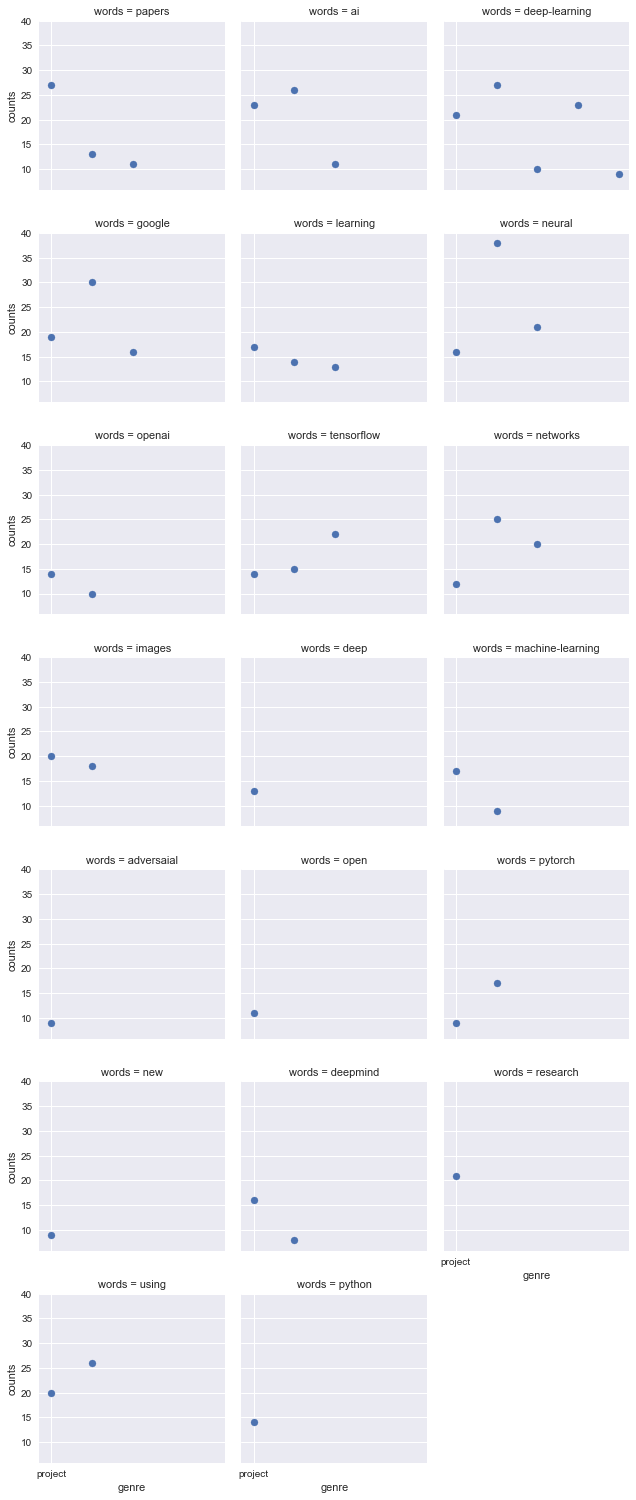

In [1819]:
import seaborn as sns
g = sns.FacetGrid(data=new_df, col = 'words', col_wrap = 3)

g.map(plt.scatter, 'genre', 'counts')
#count_plots = sns.set(rc={'figure.figsize':(15, 7)})
#plt.savefig('count_plots.pdf', dpi=400)

                words  counts  sup_counts  rep_counts       genre     ave_sup  \
30   machine-learning      80       27233        5227  discussion  340.412500   
191            papers      27       10122        2379  discussion  374.888889   
0                  ai      23        8066        1573  discussion  350.695652   
49      deep-learning      21        6047         947  discussion  287.952381   
20             google      19        5331         647  discussion  280.578947   
71           learning      17        4718         986  discussion  277.529412   
85             neural      16        4813         888  discussion  300.812500   
6              openai      14        3479        1450  discussion  248.500000   
225        tensorflow      14        4021        1362  discussion  287.214286   
80           networks      12        3468         418  discussion  289.000000   

        ave_rep  
30    65.337500  
191   88.111111  
0     68.391304  
49    45.095238  
20    34.052632  


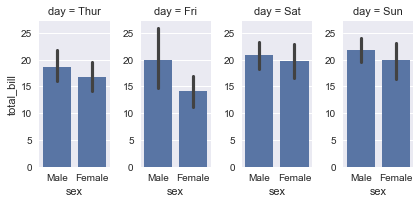

In [1786]:
print(new_df.head(10))
tips = sns.load_dataset("tips")
tips.head()
g = sns.FacetGrid(tips, col="day",aspect=.5)
g.map(sns.barplot, "sex", "total_bill")

In [1666]:
new_df1 = pd.DataFrame()
new_df1 = discussion_count1.head(30).append(research_count1.head(30))
new_df1 = new_df.append(news_count1.head(30))
new_df1 = new_df.append(general_count1.head(30))
new_df1 = new_df.append(project_count1.head(30))
#sns.barplot(x=new_df1['words'], y=new_df1['counts'], palette="BuPu")

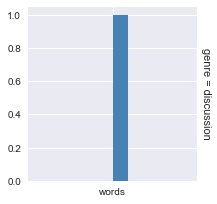

In [1646]:
sns.set(style="darkgrid")

g = sns.FacetGrid(new_df1, row="genre", margin_titles=True)
#bins = np.linspace(0, 60, 13)
g.histplot(x = "words", color="steelblue")

In [1672]:
new_df1.groupby(['words', 'genre'])['counts'].sum().sort_values(ascending = False)

words             genre     
machine-learning  project       90
                  discussion    80
using             project       52
machine-learning  general       47
deep-learning     project       46
tensorflow        project       44
neural            project       42
images            project       40
neural            general       38
pytorch           project       34
google            general       30
learning          project       28
python            project       28
ai                news          28
papers            discussion    27
deep-learning     general       27
ai                general       26
papers            project       26
networks          general       25
                  project       24
models            project       24
ai                project       24
                  discussion    23
research          general       21
neural            research      21
deep-learning     discussion    21
tutorial          project       20
using             general 

In [1511]:
new_df.loc[:,'ave_sup'] = new_df.loc[:,'sup_counts']//new_df.loc[:, 'counts']
new_df.loc[:,'ave_rep'] = new_df.loc[:,'rep_counts']//new_df.loc[:, 'counts']
new_df.sort_values('ave_sup', ascending =False)



In [1867]:
import plotly
import plotly.graph_objects as go
from IPython.display import Image
import plotly.io as pio

plotly.offline.init_notebook_mode(connected=True)
from plotly.graph_objs import Figure, Histogram, Layout
#ave_sup_fig = sns.lmplot("counts", "ave_sup", new_df,hue = 'genre',col='genre')
#ave_rep_fig = sns.lmplot("counts", "ave_rep", new_df,hue = 'genre',col='genre')
ave_sup_fig = go.Figure(data=go.Scatter(x=reddit_ml_count1['counts'],
                                y=reddit_ml_count1['ave_sup'],
                                mode='markers',
                                marker = dict(color=reddit_ml_count1['ave_sup'],
                                              colorscale='Delta',
                                             showscale=True),    
                                text=reddit_ml_count1['words']))
ave_sup_fig.update_layout(title=go.layout.Title(text="Average Support Plot"),
                  xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Words Counts")),
                  yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Average Support")))


"""
ave_rep_fig = go.Figure(data=go.Scatter(x=reddit_ml_count1['counts'],
                                y=reddit_ml_count1['ave_rep'],
                                mode='markers',
                                marker = dict(color=reddit_ml_count1['ave_rep'],
                                              colorscale='Phase',
                                             showscale=True),
                                text=reddit_ml_count1['words']))"""
"""ave_rep_fig.update_layout(title=go.layout.Title(text="Average Reply Plot"),
                  xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Words Counts")),
                  yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Average Reply")))"""


'ave_rep_fig.update_layout(title=go.layout.Title(text="Average Reply Plot"),\n                  xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Words Counts")),\n                  yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Average Reply")))'

In [1868]:
ave_sup_fig = go.Figure(data=go.Scatter(x=reddit_ml_count1['counts'],
                                y=reddit_ml_count1['ave_sup'],
                                mode='markers',
                                marker = dict(color=reddit_ml_count1['ave_sup'],
                                              colorscale='Delta',
                                             showscale=True),    
                                text=reddit_ml_count1['words']))
ave_sup_fig.update_layout(title=go.layout.Title(text="Average Support Plot"),
                  xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Words Counts")),
                  yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Average Support")))

In [1573]:
plotly.io.orca.config.executable = '/Applications/anaconda3/pkgs/plotly-orca-1.2.1-1'
plotly.io.orca.config.save()

In [1856]:
new_ratio.sample(5)

,d_counts,dsup_counts,drep_counts,genre,words
407,0.389538,0.396788,0.311902,project,project
175,0.667780,0.484482,0.272381,project,networks
86,1.446856,1.497726,1.220906,general,ai
368,0.556483,0.593279,1.292473,general,alphago
213,0.166945,0.121077,0.079044,research,notes


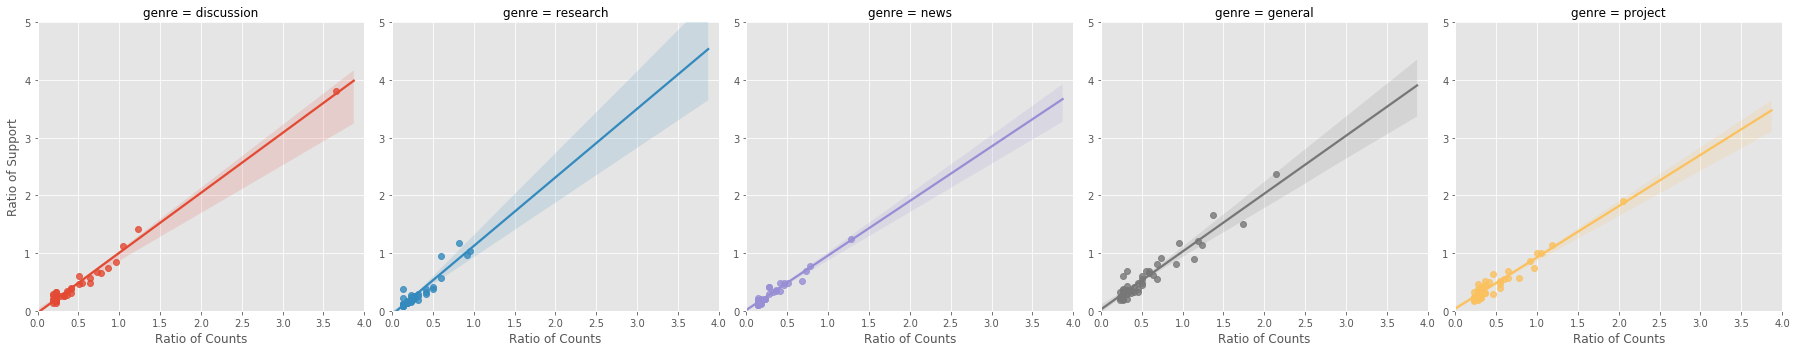

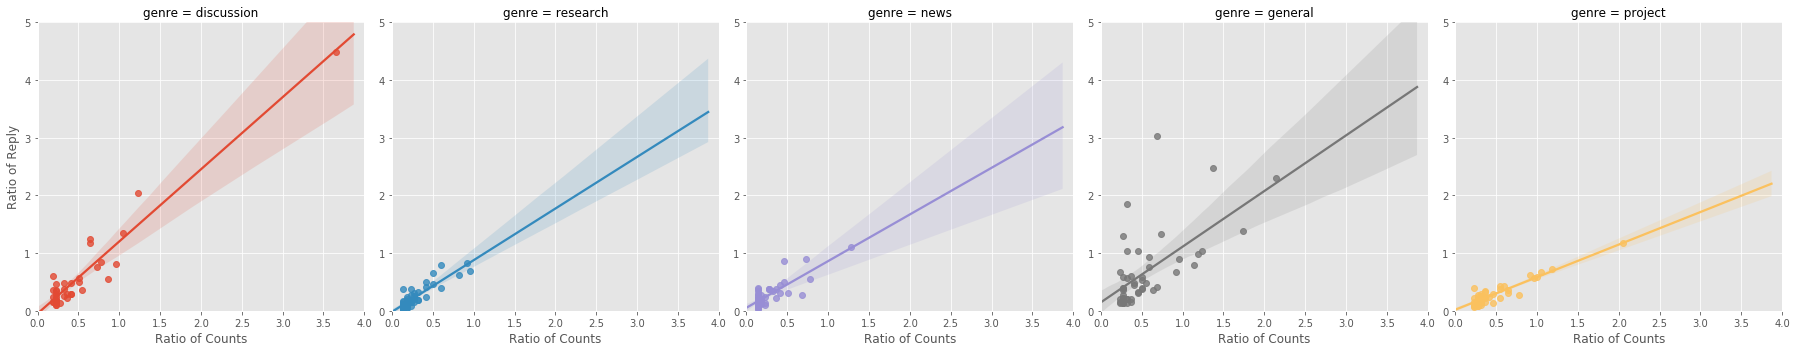

In [1478]:
sup_fig = sns.lmplot("d_counts", "dsup_counts", new_ratio,hue = 'genre',col='genre')
rep_fig = sns.lmplot("d_counts", "drep_counts", new_ratio,hue = 'genre',col='genre')
sup_fig1 = sup_fig.set(xlim = [0,1.5], ylim = [0,2.2])
rep_fig1 = rep_fig.set(xlim = [0,1.5], ylim = [0,2.2])
sup_fig1.set_axis_labels('Ratio of Counts', 'Ratio of Support')
rep_fig1.set_axis_labels('Ratio of Counts', 'Ratio of Reply')
sup_fig1.savefig("sup_fig1", format = 'pdf', dpi = 500)
rep_fig1.savefig("rep_fig1", format = 'pdf', dpi = 500)
sup_fig.set(xlim = [0,4], ylim = [0,5])
rep_fig.set(xlim = [0,4], ylim = [0,5])
sup_fig.set_axis_labels('Ratio of Counts', 'Ratio of Support')
rep_fig.set_axis_labels('Ratio of Counts', 'Ratio of Reply')
sup_fig.savefig("sup_fig", format = 'pdf', dpi = 500)
rep_fig.savefig("rep_fig", format = 'pdf', dpi = 500)

In [1451]:
import plotly.express as px
fig = px.scatter(new_ratio, x="d_counts", y="dsup_counts", color = 'words',
                 hover_data=['words'],facet_col = 'genre', trendline="ols",
                render_mode="webgl")
fig.write_image("fig1.pdf")

In [1629]:
new_ratio.columns

Index(['Counts Ratio_%', 'Support Ratio_%', 'Report Ratio_%', 'genre',
       'words'],
      dtype='object')

In [1630]:
new_ratio.rename(columns = {'d_counts':'Counts Ratio_%','dsup_counts':'Support Ratio_%',
                  'Report Ratio_%':'Reply Ratio_%'}, inplace = True)


In [1624]:
import plotly.express as px
sup_ratio = px.scatter(new_ratio,x = "Counts Ratio_%", y="Support Ratio_%", 
                       color="genre", facet_col="genre", trendline = "ols",
                      hover_name="words")

plotly.offline.iplot(sup_ratio, show_link= True, image_width=800, image_height=600)

In [1865]:

sup_ratio = px.scatter(new_ratio,x = "Counts Ratio_%", y="Reply Ratio_%", 
                       color="genre", facet_col="genre", trendline = "ols",
                      hover_name="words")

plotly.offline.iplot(sup_ratio, show_link= True, image_width=800, image_height=600)

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['d_counts', 'dsup_counts', 'drep_counts', 'genre', 'words'] but received: Counts Ratio_%

In [1432]:
from IPython.display import Image


In [ ]:
#!!!!! draw word figures
import numpy as np
from PIL import Image
import os
import re
from PIL import Image
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import ImageColorGenerator

#draw news topics
mask = np.array(Image.open("spain-flag.jpg"))
news_words = WordCloud(background_color="white", max_font_size=400,max_words=200, mask = mask,stopwords=uncommon_words)
news_words.generate(' '.join(sort_by_n_counts.loc[:50,'words']))  
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(7, 7), dpi = 200)
plt.imshow(news_words.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.title("News Topic")
plt.savefig("News_Topic_span_50", format="png")
plt.show()

# project words figure
mask = np.array(Image.open("baby.jpg"))
project_words = WordCloud(background_color="white", max_font_size=400,max_words=200, mask = mask,stopwords=uncommon_words)
project_words.generate(' '.join(sort_by_p_counts.loc[:50,'words']))  
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(7, 7), dpi = 300)
plt.imshow(project_words.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.title("Project Topic")
plt.savefig("Project_Topic_ai_50", format="png")
plt.show()

# discussion topic figure
mask = np.array(Image.open("brain.jpg"))
discussion_words = WordCloud(background_color="white",max_font_size=400, max_words=200, mask = mask,stopwords=uncommon_words)
discussion_words.generate(' '.join(sort_by_d_counts.loc[:50,'words']))  
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(7, 7), dpi = 300)
plt.imshow(discussion_words, interpolation="bilinear")
plt.axis("off")
plt.title("Discussion Topic")
plt.savefig("Discussion_Topic_ai_50", format="png")
plt.show()

# general topic figure
mask = np.array(Image.open("T-shirt.jpg"))
general_words = WordCloud(background_color="white", max_font_size=400, max_words=200, mask = mask,stopwords=uncommon_words)
general_words.generate(' '.join(sort_by_g_counts.loc[:50,'words']))  
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(7, 7), dpi = 300)
plt.imshow(general_words.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.title("General Topic")
plt.savefig("General_Topic_50", format="png")
plt.show()

#draw research figure
mask = np.array(Image.open("pipk.jpeg"))
research_words = WordCloud(background_color="white", max_font_size=400,max_words=400, mask = mask,stopwords=uncommon_words)
research_words.generate(' '.join(sort_by_r_counts.loc[:50,'words']))  
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(7, 7), dpi = 300)
plt.imshow(research_words.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.title("Research Topic")
plt.savefig("Research_Topic_50", format="png")
plt.show()


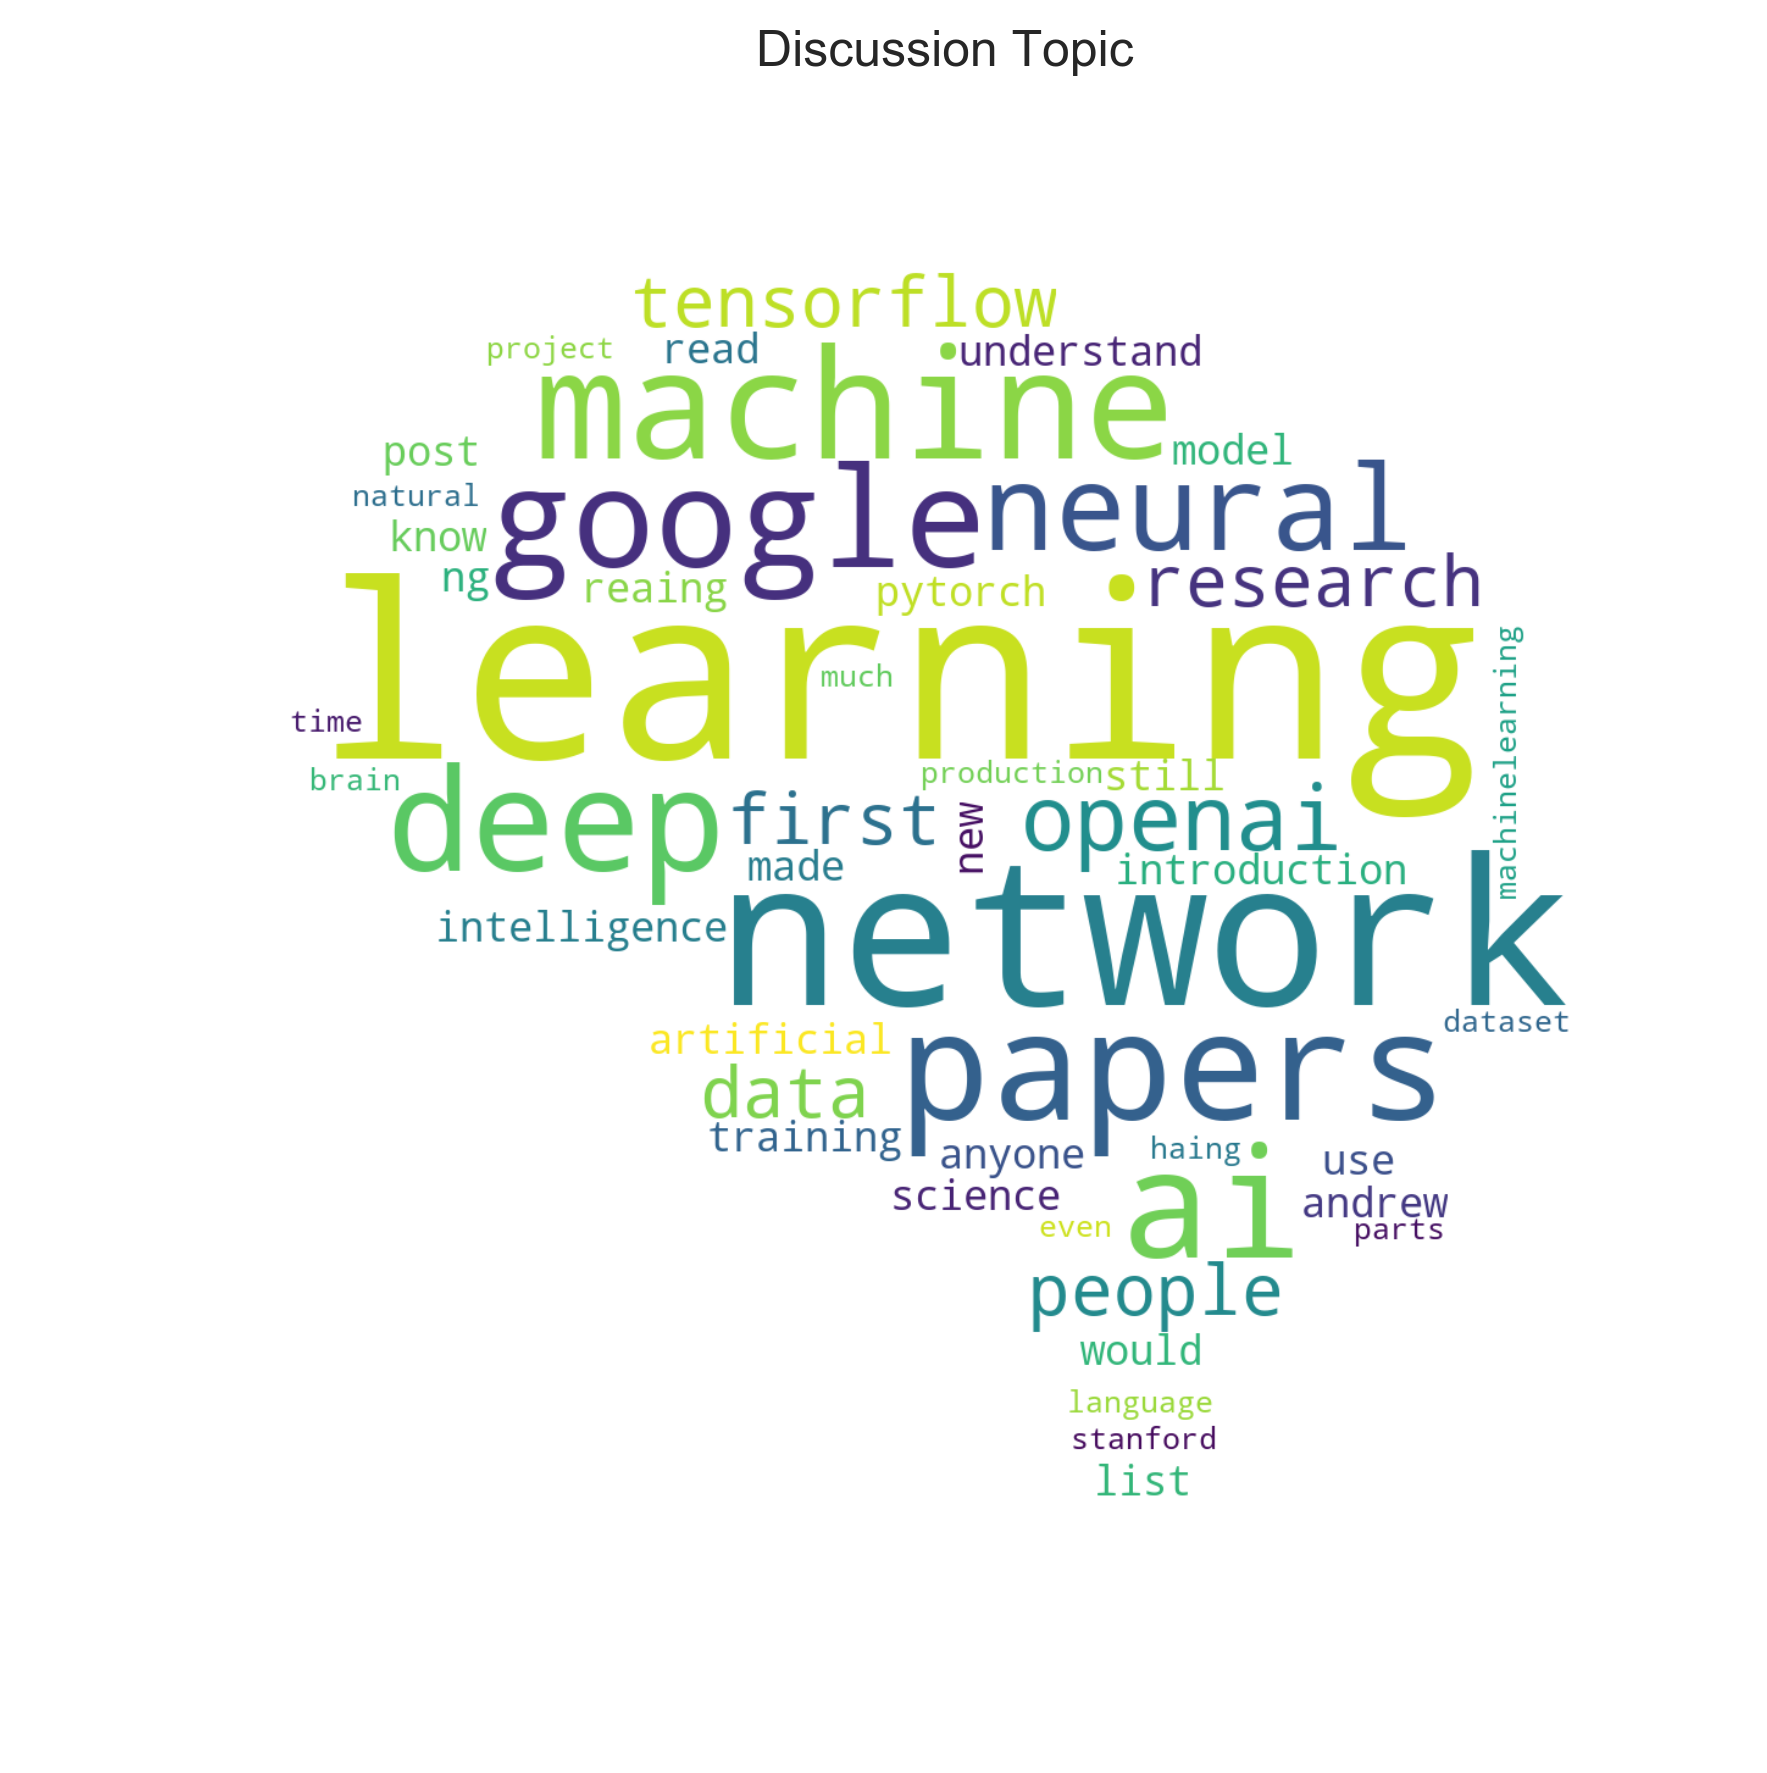

In [1870]:
import numpy as np
from PIL import Image
import os
import re
from PIL import Image
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import ImageColorGenerator
mask = np.array(Image.open("brain.jpg"))
discussion_words = WordCloud(background_color="white",max_font_size=400, max_words=200, mask = mask,stopwords=uncommon_words)
discussion_words.generate(' '.join(sort_by_d_counts.loc[:50,'words']))  
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(7, 7), dpi = 300)
plt.imshow(discussion_words, interpolation="bilinear")
plt.axis("off")
plt.title("Discussion Topic")
plt.savefig("Discussion_Topic_ai_50", format="png")
plt.show()

In [ ]:
import seaborn as sns
ratio_by_genre = pd.DataFrame()
names = count_by_genre.columns.values
for i in range(1,count_by_genre.shape[1]):
    ratio_by_genre.loc[:,names[i]] = count_by_genre.iloc[:,i]/count_by_genre.agg('sum')[i] * 100
ratio_by_genre.loc[:,names[0]] =  count_by_genre.iloc[:,0]
#ratio_by_genre[]
ratio_by_genre.head(40)



In [1427]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
"""plt.scatter(ratio_by_genre.loc[0:40,'d_counts'], ratio_by_genre.loc[0:40,'dsup_counts'], alpha = 0.2)
plt.xlim(0, 5.0)
plt.ylim(0, 5.0)"""
"""sns.lmplot("d_counts", "dsup_counts", ratio_by_genre.loc[:40,])
sns.lmplot("d_counts", "dsup_counts", ratio_by_genre.loc[1:40,])
sns.lmplot("d_counts", "drep_counts", ratio_by_genre.loc[:40,])
sns.lmplot("d_counts", "rrep_counts", ratio_by_genre.loc[1:40,])"""


'sns.lmplot("d_counts", "dsup_counts", ratio_by_genre.loc[:40,])\nsns.lmplot("d_counts", "dsup_counts", ratio_by_genre.loc[1:40,])\nsns.lmplot("d_counts", "drep_counts", ratio_by_genre.loc[:40,])\nsns.lmplot("d_counts", "rrep_counts", ratio_by_genre.loc[1:40,])'